# 03c - Record File Tree Representation

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip -q
!{sys.executable} -m pip install pandas -q
!{sys.executable}  -m pip install numpy -q
!{sys.executable}  -m pip install matplotlib -q
!{sys.executable}   -m pip install scipy -q
!{sys.executable}   -m pip install pyvis -q



In [2]:
import numpy as np
import pandas as pd
import json
import os
import pickle
from collections import OrderedDict
import psutil
import gc
from bisect import bisect
from scipy import spatial
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mplt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from pyvis.network import Network
import networkx as nx
import pandas as pd
import matplotlib.cm as cm
import resource


In [3]:
def print_txt(msg: str):
    print(msg, end = '\r')
    text_file = open("Outputs/Res_Tree_Rep.txt", "w")
    text_file.write(msg)
    text_file.close()

In [4]:
####### parameter settings #######
recreate_nodes = False
create_nodes_nw = True
plot_clusterdist = False
node_threshold = 50
edge_threshold = 10
edge_prob_threshold = 0.01
prob_threshold = 0.05
max_numclust = 20
tw = 120 #timewindow
threshold_plot = False
elo = 'high'

time_list = [t for t in range(0,5001,tw)]
time_list_long = [t for t in range(0,15000,tw)]

resource_binsize = 50
global resource_bins
resource_bins = [ub for ub in range(0,120000,resource_binsize)]
global resrate_bins
resrate_bins = [ub for ub in np.arange(0,100,0.5)]

In [5]:
##directorys
input_path = 'data/scraped_matches/inputs/'
gaia_path = 'data/scraped_matches/gaia_data/'
viz_path = 'Visualizations/Tree_Rep/'

#players
player_ids = ['p1','p2']

In [6]:
#load masterdata
with open('masterdata/masterdata_dict.pkl', 'rb') as f:
        masterdata_dict = pickle.load(f)

with open('masterdata/unit_type_dict.pkl', 'rb') as f:
        unit_type_dict = pickle.load(f)        

with open('masterdata/unit_masterdata_dict.pkl', 'rb') as f:
        unit_masterdata_dict = pickle.load(f)        

#load masterdata
with open('masterdata/elo_frames.pkl', 'rb') as f:
        elo_frames = pickle.load(f)
        
#master data
with open(f'masterdata/full_resource_masterdata_dict.pkl', 'rb') as f:
        resource_masterdata = pickle.load(f)
        
resources = ['Food','Wood','Gold','Stone']
elo_frames

{'low': {'lb': 0, 'ub': 1062, 'label': 'Low Elo'},
 'medium': {'lb': 1062, 'ub': 1501, 'label': 'Medium Elo'},
 'high': {'lb': 1501, 'ub': 3000, 'label': 'High Elo'}}

In [7]:
def get_eloFrame(elo,elo_frames):
    for elo_key in elo_frames:
        if elo >= elo_frames[elo_key]['lb'] and elo < elo_frames[elo_key]['ub']:
            return elo_key

def get_resbin(value):
    for ub in resource_bins:
        if value <= ub:
            return ub
        
def get_resrate(state_resource_spend,tf):
    rate = state_resource_spend/tf
    for ub in resrate_bins:
        if rate <= ub:
            return int(ub * 10)

In [8]:
get_resrate(200,120)

20

In [9]:
#load data
with open('data/scraped_matches/parsed_matches/arabia_matches.pkl', 'rb') as f:
    org_matches = pickle.load(f)

    
for match_id in org_matches:
    org_matches[match_id]['avg_elo'] = int((org_matches[match_id]['p1_elo']+org_matches[match_id]['p2_elo'])/2)
    org_matches[match_id]['elo'] = get_eloFrame(org_matches[match_id]['avg_elo'],elo_frames)

matches = org_matches    
if False:
    matches = {}
    for key in org_matches:
        matches[key] = org_matches[key]
        if len(matches) >= 10:
            break



In [10]:
"""
e = 0
g= 0
del_ids = []
#go through matches
for match_id in matches:
    try:
        with open(matches[match_id]['input_fn'], 'rb') as f:
            inputs = pickle.load(f)
        g+=1
    except:
        e+=1
        del_ids.append(match_id)
        
for match_id in del_ids:
    del matches[match_id]

print(g,e)
"""

"\ne = 0\ng= 0\ndel_ids = []\n#go through matches\nfor match_id in matches:\n    try:\n        with open(matches[match_id]['input_fn'], 'rb') as f:\n            inputs = pickle.load(f)\n        g+=1\n    except:\n        e+=1\n        del_ids.append(match_id)\n        \nfor match_id in del_ids:\n    del matches[match_id]\n\nprint(g,e)\n"

In [11]:
simple = False
military_comp = True

### 3-D Tree Vills, Military, Epoch
global tree_dims 

key_types = ['Build','Queue','Research']
#rel_items = ['Villager', 'Loom', 'Build', 'Queue', 'Research']
id_prefix = 'ID'

########################complex setting########################
tree_dims = ['tf','Age'] #["Villager","Military","Research"]
#load tree_dims from masterdata
for key_type in key_types:
    for sub_type in masterdata_dict[key_type]:
        tree_dims.append(sub_type)
########################simple setting########################
#overwriting complex
if simple:
    tree_dims = ['tf','Age',"Villager","Military","Build","Research"]

    
########################military composition setting########################
if military_comp:
    full_tree_dims = tree_dims.copy()
    tree_dims = ['tf','Age','resrate']
    for type in unit_type_dict:
        print(type)
        tree_dims.append(type)
    
#############################################################################    
    
def get_node_id(state: dict):
    """get a node id string from a given game state dict"""
    id = id_prefix
    for dim in tree_dims:
        if state[dim] > 0:
            id += f'_{dim}_{state[dim]}'
    return id

def get_node_state(id: str):
    """get a node game state from a given node id string"""
    state = {}
    
    id = id[len(id_prefix):]
    state_list = id.split("_")[1:]
    
    while len(state_list)>0:
        #read vals in dict
        dim = state_list[0]
        val = state_list[1]
        state[dim] = int(val)
        #update statelist
        state_list = state_list[2:]
        
    for dim in tree_dims:
        if dim not in state:
            state[dim] = 0
    
    return state



class TreeNode:
    """3D Tree Node Class with Dimensions Villiagers, Military Units and Epoch"""
    
    def __init__(self, id):
        
        self.id = id
        
        #win/loss stat
        self.visits = 0
        self.win = 0
        self.loss = 0
        
        self.elos = {}
        for elo_key in elo_frames:
            self.elos[elo_key] = 0
        
        #get node state from function
        self.state = get_node_state(self.id)
        
        #add up all items from state
        self.age = self.state['Age']
        self.tf = self.state['tf']
        self.resrate =  self.state['resrate']
        self.level = 0
        for item in self.state:
            self.level += self.state[item]
            
        #create vector without tf info
        self.state_vector = [self.level]
        for dim in tree_dims[1:]:
            if dim in self.state:
                self.state_vector.append(self.state[dim])
            else:
                self.state_vector.append(0)
        
        
        #incomming and outcomming edges
        self.in_edges = {}
        self.out_edges = {}
        
        self.in_nodes = []
        self.out_nodes = []
        
        #init cluster allocation
        self.cluster_id = "init"
        
    def update_stats(self):
        self.visits = self.win + self.loss
        self.winrate = self.win/self.visits
        
def use_edge(out_node: TreeNode,in_node: TreeNode, bol_win: bool,elo):
    """update the edge values for the transition from one game state value to another"""
    
    #add values
    if bol_win:
        in_node.win +=1
    else:
        in_node.loss +=1
        
    #update elo
    in_node.elos[elo] +=1
    
    #add edge or edgecount for out and in node
    if in_node.id in out_node.out_edges:
        out_node.out_edges[in_node.id] += 1
    else:
        out_node.out_edges[in_node.id] = 1
        
    if out_node.id in in_node.in_edges:
        in_node.in_edges[out_node.id] += 1
    else:
         in_node.in_edges[out_node.id] = 1
    
    #add to in_node/out_nodes list
    out_node.out_nodes.append(in_node)
    in_node.in_nodes.append(out_node)
            
    #update stats
    in_node.update_stats()

def get_distance(node1: TreeNode, node2: TreeNode):
    """return cosine similarity between 2 TreeNodes"""
    dist = (spatial.distance.cosine(node1.state_vector,node2.state_vector))
    return dist
    
    
class TreeNodeCluster:
    def __init__(self,idx,tf, nodes: list):
        self.idx = idx
        self.id = "init"
        self.tf = tf
        self.resrate = 0
        self.lvlval = 0
        
        self.nodes = nodes
        self.size = len(nodes)
    
        
        self.state_keys = []
        
        #lower and upper bounds
        self.state_lbs = {}
        self.state_ubs = {}
        self.state_avgs = {}
        self.level_ub = 0
        
        #win/loss stat
        self.visits = 0
        self.win = 0
        self.loss = 0
        self.winrate = 0
        
        #intra distance
        self.avg_intra_dist = 0
        
        self.label = "init"
        self.dominant_key = "init"
        self.update_stats()
        
        #edges
        self.in_edges = {}
        self.out_edges = {}
        
        #allocate nodes to cluster
        for node in self.nodes:
            node.cluster_id = self.id
        
        
        
    def update_stats(self):
        
        #reset vals
        self.visits = 0
        self.win = 0
        self.loss = 0
        max_state_val = 0
        
        #loop over nodes 
        for node in self.nodes:
            self.visits += node.visits
            self.win += node.win
            self.loss += node.loss
            self.winrate = self.win/self.visits
            
            for state_key in node.state:
                try:
                    #check if state is already there
                    if state_key not in self.state_keys:
                        self.state_keys.append(state_key)
                        self.state_lbs[state_key] = node.state[state_key]
                        self.state_ubs[state_key] = node.state[state_key]
                        self.state_avgs[state_key] = node.state[state_key] * node.visits
                        
                    else:
                        if self.state_lbs[state_key] > node.state[state_key]:
                                self.state_lbs[state_key] = node.state[state_key]
                        if self.state_ubs[state_key] < node.state[state_key]:
                                self.state_ubs[state_key] = node.state[state_key]
                        
                        #add state info
                        self.state_avgs[state_key] += node.state[state_key] * node.visits            
                                
                except:
                    print("error:",self.state_lbs[state_key],node.state[state_key])
                
                #update level
                self.level_ub += self.state_ubs[state_key]

            
        #find dominant key
        for state_key in self.state_keys:
            if state_key != 'tf' :
                self.state_avgs[state_key] = round(self.state_avgs[state_key] / self.visits,2)
                if state_key != 'resrate':
                    if self.state_avgs[state_key] > max_state_val:
                        max_state_val = self.state_avgs[state_key] #
                        self.dominant_key = state_key
                
        
        #create label
        self.label = "ID"
        if self.dominant_key != "init":
            self.label += "_" + self.dominant_key
        for state_key in self.state_keys:
            if self.state_ubs[state_key] > 0:
                if self.state_lbs[state_key] == self.state_ubs[state_key]:
                     self.label += f'_{state_key}_{self.state_lbs[state_key]}'
                else:
                    self.label += f'_{state_key}_{self.state_lbs[state_key]}-{self.state_ubs[state_key]}-(AVG: {self.state_avgs[state_key]})'
        
        
        #loop over nodes 
        total_dist = 0
        c = 0
        for node1 in self.nodes:
            for node2 in self.nodes:
                total_dist += get_distance(node1,node2)
                if node1 != node2:
                    c += 1
        if c != 0:
            self.avg_intra_dist = total_dist/c
        
        #finalize values
        self.id = self.label
        self.resrate = self.state_avgs['resrate']
        self.lvlval = (self.resrate*0.005 + self.tf *00.1)*0.1
        
    def get_cluster_edges(self):
        for intern_node in self.nodes:
            #in edges
            for extern_node in intern_node.in_nodes:
                if extern_node.cluster_id == "init":
                    pass
                else:
                    if extern_node.cluster_id not in self.in_edges:
                        self.in_edges[extern_node.cluster_id] = 1
                    else:
                        self.in_edges[extern_node.cluster_id] += 1
            
            #out_edges
            for extern_node in intern_node.out_nodes:
                if extern_node.cluster_id == "init":
                    pass
                else:
                    if extern_node.cluster_id not in self.out_edges:
                        self.out_edges[extern_node.cluster_id] = 1
                    else:
                        self.out_edges[extern_node.cluster_id] += 1

                    
def norm_vectors(vectorset: list):
    """ Normalize vecotors in a list of vectors"""
    for idx,vector in enumerate(vectorset):
        vectorset[idx].append(1)
        
    
    #create empty max vector
    max_vector = [0 for e in vectorset[0]]

    for vector in vectorset:
        for idx,val in enumerate(vector):
            if val > max_vector[idx]:
                max_vector[idx] = val
                
    normed_vectorset = vectorset
    
    for vec_idx,vector in enumerate(vectorset):
        for val_idx,val in enumerate(vector):
            if max_vector[val_idx] != 0:
                normed_vectorset[vec_idx][val_idx] = round(val / max_vector[val_idx],10)
    
    return normed_vectorset

Villager
Monk
Trade Cart
Infantry
Foot Archer unit
Cavalry
Siege unit
Gunpowder
Ship
Mounted Archer


In [12]:
#create root node from empty gamestate
init_state = {}
for dim in tree_dims:
    init_state[dim] = 0

if recreate_nodes:
    #create nodedict
    nodes = {}

    root_node_id = get_node_id(init_state)
    nodes[root_node_id] = TreeNode(root_node_id)

    #collect stats
    stat_list = []


    ############LOOP#####################


    for index,match_id in enumerate(matches):
        #determine winner and elo of each match
        winner = player_ids[matches[match_id]['winner']]
        elo = matches[match_id]['elo']
        #open inputs
        with open(matches[match_id]['input_fn'], 'rb') as f:
                    inputs = pickle.load(f)
        

        #only get inputs from active player
        for p_id in player_ids:
            #reset timeslot, init timeframes
            tf = 0
            timeframes = OrderedDict()

            #initialize new session for every player
            state = {}
            for dim in tree_dims:
                state[dim] = 0
                
            if p_id == winner:
                win = True
            else:
                win = False
            
            #track resource spending for rate
            state_resource_spend = 0
            
            #visit root node
            if win:
                nodes[root_node_id].win += 1
            else:
                nodes[root_node_id].loss += 1
            
            nodes[root_node_id].elos[elo] +=1    
                
            nodes[root_node_id].update_stats()
            curr_node = nodes[root_node_id]

            #sort inputs into timeframe slices
            for input_id in inputs:
                if inputs[input_id]['player'] == p_id:
                #only select from player
                    if inputs[input_id]['ts_seconds'] < tf:
                        timeframes[tf].append(input_id)
                    else:
                        #create new timeframe
                        tf += tw
                        timeframes[tf] = []
                        timeframes[tf].append(input_id)

                
            for tf in timeframes:
                #update tf
                state['tf'] = tf 

                for input_id in timeframes[tf]:
                    input = inputs[input_id]
                    if input['type'] in key_types:
                    #only select from key type

                    ##STATE UPDATE after Input ######################
                        ########################complex setting########################
                        if not simple and not military_comp:
                            if input['param'] in masterdata_dict['Ages']:
                                #handle ages
                                state['Age'] = masterdata_dict['Ages'].index(input['param']) + 1
                            else:
                                
                            #all other intputs    
                                if input['param'] in state and input['param'] != '':
                                    state[input['param']] += int(resource_masterdata[input['param']]['total_resources'])
                                else:
                                    state[input['param']] = int(resource_masterdata[input['param']]['total_resources'])

                                
                        ########################military comp setting########################        
                        elif military_comp:
                            #print(input['param'], )
                            if input['param'] != 'None' and input['param'] != 'Villager' and input['param'] != '':
                                #handle ages
                                if input['param'] in masterdata_dict['Ages']:  
                                    state['Age'] = masterdata_dict['Ages'].index(input['param']) + 1
                                #handles military and vills
                                if input['type'] == 'Queue':
                                    state[unit_masterdata_dict[input['param']]['Type']] += int(resource_masterdata[input['param']]['total_resources'])
                                state_resource_spend += resource_masterdata[input['param']]['total_resources']
                                    
                        ########################simple setting########################        
                        else:
                            #handle ages
                            if input['param'] in masterdata_dict['Ages']:  
                                state['Age'] = masterdata_dict['Ages'].index(input['param']) + 1

                            elif input['type'] == 'Research':
                                state['Research'] += 1

                            elif input['type'] == 'Build':
                                state['Build'] += 1

                            #handles military and vills
                            elif input['type'] == 'Queue':
                                if input['param'] == 'Villager':
                                    state['Villager'] +=1
                                else:
                                    state['Military'] +=1

                        ################################################################## 



                ############################## NODE UPDATE after TF ############################
                #turn resource to int:
                state['resrate'] = get_resrate(state_resource_spend,tf)#int((state_resource_spend/tf)*10)
            
                ## get target node id
                next_node_id = get_node_id(state)

                #check for double click ups
                if not curr_node.id == next_node_id:

                    ##check if node exists, if not create it
                    if next_node_id not in nodes:
                        nodes[next_node_id] = TreeNode(next_node_id)

                    ##use edge and visit node
                    use_edge(curr_node,nodes[next_node_id], win, elo)


                    ##update current node
                    curr_node = nodes[next_node_id]

        #log and delete
        if index % 1000==0:
            print_txt(f'Match {index}/{len(matches)} - Nodes: {len(nodes)} -Memory: {str(psutil.virtual_memory()[2])} %')
            stat_list.append(len(nodes))
            gc.collect()

                
    #persistate
    max_rec = 0x100000
    resource.setrlimit(resource.RLIMIT_STACK, [0x100 * max_rec, resource.RLIM_INFINITY])
    sys.setrecursionlimit(max_rec)
    output = open('data/res_nodes.pkl' , 'wb')
    pickle.dump(nodes, output)
    output.close() 
    
else:
    root_node_id = get_node_id(init_state)
    with open('data/res_nodes.pkl', 'rb') as f:
        nodes = pickle.load(f)
    print(f'{len(nodes)} Nodes loaded from pkl')
    

2390756 Nodes loaded from pkl


In [13]:
if False:
    figure(figsize=(10, 10), dpi=50)
    x_axis = [ 1000 * i for i in range(int(len(matches)/1000))]
    ax = plt.gca()
    ax.tick_params(axis='y', which='major', labelsize=5)
    ax.set_xlim([0, len(matches)])
    plt.plot(x_axis,stat_list)
    plt.show()

In [14]:

if threshold_plot:
    x_th = []
    y_th = []
    threshold = 0
    last_len = 51

    while last_len > 50 and threshold < 200:

        rel_nodes = []
        rel_node_ids = []

        for node_id in nodes:
            #node.state_vector.pop(0)
            curr_node = nodes[node_id]
            if curr_node.visits >= threshold:# or curr_node.winrate > 0.6 and curr_node.winrate < 0.99 and curr_node.visits >= 10: 
                rel_nodes.append(curr_node)
                rel_node_ids.append(node_id)
                #print(curr_node.visits, "-", curr_node.winrate,"-",curr_node.id)

        x_th.append(threshold)
        y_th.append(len(rel_nodes))

        if threshold > 500:
            threshold += 10
        else:
            threshold += 1
        last_len = len(rel_nodes)
        print_txt(f'Threshold: {threshold} - Len: {last_len}                           ')

In [15]:
if threshold_plot:
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    figure(figsize=(6, 6))
    ax = plt.gca()
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.set_xlim([0, x[-1]])
    ax.set_ylim([0, 20000])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=10, color='grey')
    #plt.title('Remaining Nodes per Threshold',fontsize=14)
    plt.xlabel("Set Threshold",fontsize=14)
    plt.ylabel("Remaining Nodes",fontsize=14)
    plt.plot(x_th,y_th)
    plt.grid(which = 'major',color='lightgrey', linestyle='-', linewidth=2)
    plt.savefig(viz_path + 'nodes_per_th')
    plt.show()


In [16]:
rel_nodes = []
rel_node_ids = []

for node_id in nodes:
    #node.state_vector.pop(0)
    curr_node = nodes[node_id]
    if curr_node.visits >= node_threshold and curr_node.tf <= 1340:# or curr_node.winrate > 0.6 and curr_node.winrate < 0.99 and curr_node.visits >= 10: 
        rel_nodes.append(curr_node)
        rel_node_ids.append(node_id)
        #print(curr_node.visits, "-", curr_node.winrate,"-",curr_node.id)
        

2390756 3466


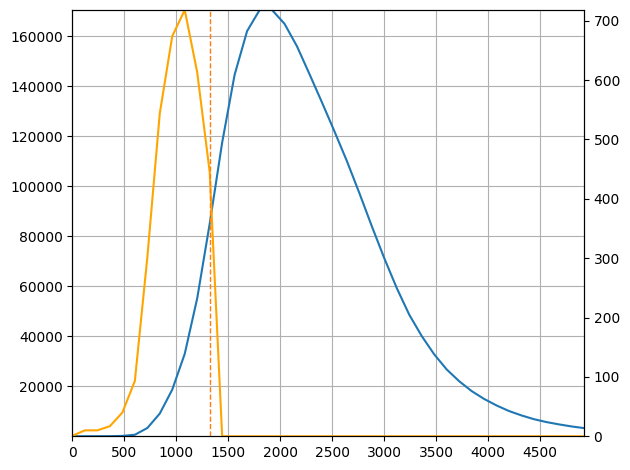

In [17]:
print(len(nodes),len(rel_nodes))
#rel_nodes = rel_nodes[:1000]
tf_node_dict = {}
tf_rel_node_dict = {}

for tf in time_list:
    tf_node_dict[tf] = 0
    tf_rel_node_dict[tf] = 0
    
for node_id in nodes:
    node_tf = nodes[node_id].tf
    if node_tf <= 5000:
        tf_node_dict[node_tf] +=1
    
for node_id in rel_node_ids:
    tf_rel_node_dict[nodes[node_id].tf] +=1
    
tf_node_df = pd.DataFrame.from_dict(tf_node_dict,orient='index')
tf_rel_node_df = pd.DataFrame.from_dict(tf_rel_node_dict,orient='index')

fig,ax1 = plt.subplots()
ax1.plot(tf_node_df)
ax2 = ax1.twinx()
ax2.plot(tf_rel_node_df.iloc[:2000],color='orange')
plt.xticks(range(0,5000,500))
plt.axvline(1320, linestyle='dashed', linewidth=1,color='tab:orange')

ax1.grid()
ax1.margins(x=0.00,y=0)
ax2.margins(x=0.00,y=0)
plt.tight_layout()
plt.show()

In [18]:
#max tf 1320


In [19]:
if create_nodes_nw:
    seq_net = Network(height='750px', width='100%', bgcolor='#FFFFFF', font_color='black',notebook=True,  directed=True, layout = True) #

    # set the physics layout of the network
    #seq_net.barnes_hut()

    #colorpalette
    cmap = cm.get_cmap('bwr_r')

    #shapelist:
    shapes = ['dot','triangle','square','star']

    #add nodes
    for node in rel_nodes:
        #determin color by winrate
        color = mplt.colors.to_hex(cmap(int(node.winrate*255)))

        seq_net.add_node(node.id, color = color,
                         label = str(round(node.winrate,2)) + "_" + str(node.visits), 
                         value = node.visits, title = node.id , level = node.tf*0.05+node.resrate*0.1, 
                         Y= node.level, x = node.level , shape = shapes[node.age]) #level=

    for node in rel_nodes:
        for out_node_id in node.in_edges:
            out_node = nodes[out_node_id]
            if out_node in rel_nodes:
                #if node.in_edges[out_node.id] >= out_node.visits*prob_threshold:#edge_threshold:#and abs(round(node.winrate-out_node.winrate,2)) > 0.05 :
                seq_net.add_edge(out_node.id, node.id, value=node.in_edges[out_node.id],title=f'Prob: {round(node.in_edges[out_node.id]/out_node.visits,2)} - Use: {node.in_edges[out_node.id]}-  WRD: {round(node.winrate-out_node.winrate,2)}')


    seq_net.toggle_physics(False)
    seq_net.save_graph('res_seq_net.html')
    #seq_net.show('res_seq_net.html')


In [20]:
numclust = max_numclust
numclust_dist_dict = {}
tf_node_dict = {}

#for numclust in range(max_numclust-1,max_numclust):
if True:    
    #collect statistics for all numbers of clusters in the range
    numclust_dist_dict[numclust] = {}
    

    curr_tf = 0
    snapshot_tf = 600
    cluster_dict = {}
    size_limit = 100000000000

    #initilize tf list und root cluster mit root node
    tf_list = [0]
    cluster_dict[curr_tf] = {}
    cluster_dict[curr_tf][0] = TreeNodeCluster(0,0,[nodes[root_node_id]])
    
    
    while True:
        print_txt(f'Curr Numclust: {numclust} - Curr_tf: {curr_tf}')
        curr_tf += tw
        tf_node_dict[curr_tf] = []
        
        #for each timeframe slice - cluster nodes around mainlines with weighted distance between states distance in higher number is maller than in lower number
        node_list = []
        ordered_node_list = []
        visit_list = []
        
        #use euclidan distance, avoid join in case of big wr gap, add cost function for 


        #order select nodes in from tf and order by number of visits
        for node in rel_nodes:
            if node.state['tf'] == curr_tf:
                idx = bisect(visit_list, node.visits)
                ordered_node_list.insert(idx,node)
                visit_list.insert(idx,node.visits)
                tf_node_dict[curr_tf].append(node)
                
                
        ordered_node_list.reverse()

        #if no more rel_nodes break
        if len(ordered_node_list) == 0:
            #print_txt(f'No more at tf {curr_tf}')
            break
        else:
            cluster_dict[curr_tf] = {}
            tf_list.append(curr_tf)

        #enforce size_limit if set
        ordered_node_list = ordered_node_list[:size_limit]

        x = [node.id for node in ordered_node_list]
        y = [node.state_vector.copy() for node in ordered_node_list]
        y_norm = norm_vectors(y)

        #create denogram
        linkage_data = linkage(y_norm, method='average', metric='cosine')

        if curr_tf == snapshot_tf:
            link_exp = linkage_data.copy()
            x_exp = x.copy()


        cluster_dict[curr_tf] = {}
        #for clusters and sort into list and create TreeNodeClusters

        ##cluster
        fcluster_list = fcluster(linkage_data,numclust,criterion='maxclust')
        ##read into clusters into list dict
        clusters = {}
        for idx in range(numclust):
            clusters[idx] = []

        for idx, i in enumerate(fcluster_list):
            clusters[i-1].append(ordered_node_list[idx])

        ##convert into TreeNodeCluster and collect distance
        total_dist = 0
        c = 0
        for c_id in clusters:
            if len(clusters[c_id]) > 0:
                cluster_dict[curr_tf][c_id] = TreeNodeCluster(c_id,curr_tf,clusters[c_id])
                total_dist += cluster_dict[curr_tf][c_id].avg_intra_dist
                c += 1

        #get dist stats
        numclust_dist_dict[numclust][curr_tf] = total_dist/c
        
        
    #loop over all clusters and add edges and add to global cluster dict do lopp more conveniet and address by id
    glob_cluster_dict = {}

    for curr_tf in tf_list:
        for c_id in cluster_dict[curr_tf]:
            cluster_dict[curr_tf][c_id].get_cluster_edges()
            glob_cluster_dict[cluster_dict[curr_tf][c_id].id] = cluster_dict[curr_tf][c_id]
            #print(cluster_dict[curr_tf][c_id].id,cluster_dict[curr_tf][c_id].out_edges, glob_cluster_dict[cluster_dict[curr_tf][c_id].id].out_edges)

print_txt(f'{len(glob_cluster_dict)} Clusters found')
output = open('data/tree_rep/res_numclust_dist_dict.pkl' , 'wb')
pickle.dump(numclust_dist_dict, output)
output.close() 
output = open('data/tree_rep/res_tf_list.pkl' , 'wb')
pickle.dump(tf_list, output)
output.close() 

/home/niel/.conda/envs/aoeanalytics2/lib/python3.8/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [21]:
tf_node_dict.keys()

dict_keys([120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440])

In [22]:
tf_list

tf_list_short = [i for i in range(480,2000,240)]#[600,960,1200,1440,1800]

labels = []
for tf in tf_node_dict:
    labels.append(f'TF: {tf} ({len(tf_node_dict[tf])} rem. nodes)')

In [23]:
if plot_clusterdist:

    fig, ax = plt.subplots()

    fig.figsize=(6,6)
    ax.set_xlim([2, max_numclust])
    ax.set_ylim([0, 0.00004])
    plt.xlabel("Number of Clusters",fontsize=14)
    plt.ylabel("Mean Intra Cluster Distance",fontsize=14)
    plt.grid(color='lightgrey', linestyle='-', linewidth=2)

    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.yaxis.offsetText.set_fontsize(14)

    #plt.title(f'Avg Intra Cluster Distance per Number of Clusters')

    for tf in tf_list_short:#tf_list[1:]:
        x = [i for i in range(2,max_numclust)]
        y = [numclust_dist_dict[numclust][tf] for numclust in x]
        if len(x)>0:
            ax.plot(x,y)
    #ax = plt.gca()


    ax.legend(labels,fontsize=14)
    plt.tight_layout()
    plt.savefig(viz_path +f'Clusterdist_numclust_time.png')
    plt.show()




In [24]:
#get info about snapshot
if False:
    curr_tf = snapshot_tf
    for c_id in cluster_dict[curr_tf]:
        print(cluster_dict[curr_tf][c_id].visits,round(cluster_dict[curr_tf][c_id].winrate,2),cluster_dict[curr_tf][c_id].id,cluster_dict[curr_tf][c_id].avg_intra_dist)

In [25]:
#Plot Dendogram

if False:
    figure(figsize=(16, 10), dpi=50)
    plt.rcParams.update({'font.size': 22})
    dendrogram(link_exp,labels =x_exp, orientation='right')
    ax = plt.gca()
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.set_xscale('linear')
    ax.set_xlim([0, 0.1])
    ax.set_xlabel('Cluster Distance(Cosine Similarity)',fontsize=16)
    #ax.set_ylabel('Nodes',fontsize=16)
    plt.tight_layout()
    plt.savefig(viz_path+ f"Dendogram_tf{snapshot_tf}.png")
    plt.show()


In [57]:

seq_net_clust = Network(height='1440px', width='100%', bgcolor='#FFFFFF', font_color='black',
                        notebook=True,  directed=True, layout = True) #

# set the physics layout of the network
#seq_net.barnes_hut()
early_tf = 0
weight_threshold = 15000
prob_threshold = 0.01
#colorpalette
cmap = cm.get_cmap('bwr_r')

#shapelist:
shapes = ['dot','triangle','square','star','diamond','triangleDown','icon']
#shapedict:
shape_dict = {'init': 'dot','resrate': 'dot','Age': 'dot','Villager' :'dot', 'Monk':'dot', 'Trade Cart':'dot', 
              'Infantry':'triangle', 'Foot Archer unit':'square', 'Cavalry':'star', 
              'Siege unit':'diamond', 'Gunpowder':'triangleDown', 'Ship':'icon', 'Mounted Archer':'square'}

#add cluster_nodes
for clust_id in glob_cluster_dict:
        cluster = glob_cluster_dict[clust_id]
        #determin color by winrat
        
        color = mplt.colors.to_hex(cmap(int(cluster.winrate*255)))
        seq_net_clust.add_node(cluster.id, color = color,
                               label = str(round(cluster.winrate,2)) + "_" + str(cluster.visits), 
                               value = cluster.visits, title = cluster.label , 
                               level = int(round(cluster.lvlval,2)*1000)/500,#(cluster.tf*0.01), 
                               x = cluster.winrate, shape=shape_dict[cluster.dominant_key]) #level= # shape

for clust_id in glob_cluster_dict:
    in_clust = glob_cluster_dict[clust_id]
    for out_clust_id in in_clust.in_edges:
        out_clust = glob_cluster_dict[out_clust_id]
        #print(out_clust_id)
        prob = round(in_clust.in_edges[out_clust.id]/out_clust.visits,2)
        use = in_clust.in_edges[out_clust.id]
        
        if use >= weight_threshold:
            weight_use = weight_threshold
        else: weight_use = use
        
        if in_clust.in_edges[out_clust.id]/out_clust.visits >= prob_threshold or in_clust.tf <= early_tf:#in_clust.in_edges[out_clust.id] >= edge_threshold:#and abs(round(node.winrate-out_node.winrate,2)) > 0.05 :
            seq_net_clust.add_edge(out_clust.id, in_clust.id, value=weight_use,
                                   title=f'Prob: {prob} - Use: {use}-  WRD: {round(in_clust.winrate-out_clust.winrate,2)}')

#seq_net_clust.font_size=300

In [58]:
 cluster.tf *0.01 + cluster.resrate*0.005

13.4106

In [59]:
seq_net_clust.toggle_physics(False)
seq_net_clust.save_graph('res_seq_net_clust.html')
seq_net_clust.show('res_seq_net_clust.html')